In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
import numpy as np 
import pandas as pd 
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

import pandas as pd
df1 = pd.read_csv('/content/drive/MyDrive/Data/WN23_PA_training_tweets.txt', delimiter=',', encoding = 'iso-8859-1')
df2 = pd.read_csv('/content/drive/MyDrive/Data/WN23_PA_training_labels.txt', delimiter=',', encoding='iso-8859-1')

train_df = pd.merge(df1, df2, on='TweetID')
test_df = pd.read_csv('/content/drive/MyDrive/Data/WN23_PA_test_tweets.txt', delimiter=',', encoding='iso-8859-1')

In [77]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [78]:
%%capture
! pip install transformers
! pip install -q datasets
! pip install tesseract-ocr
! pip install -q pytesseract
! pip install -q git+https://github.com/huggingface/transformers.git

In [79]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
#from imutils import paths
import os
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from random import shuffle
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras import layers
import datetime
from tensorflow.keras.models import Model
from transformers import TFBertModel, BertConfig
from PIL import Image
import pytesseract
import re
import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import zipfile
import tempfile
import string
from PIL import Image #, ImageDraw, ImageFont
#from PIL import ImageOps
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english')) 
tf.test.is_gpu_available(cuda_only=True)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [80]:
train_df = train_df[['Tweet','Label']]

In [81]:
def clean_text(text):
    text=str(text).lower() #Converts text to lowercase
    text=re.sub('\d+', '', text) #removes numbers
    text=re.sub('\[.*?\]', '', text) #removes HTML tags
    text=re.sub('https?://\S+|www\.\S+', '', text) #removes url
    text=re.sub(r"["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", "", text) #removes emojis
    text=re.sub('[%s]' % re.escape(string.punctuation),'',text) #removes punctuations
    #text = re.sub('\n', '', text)
    #text = re.sub('\w*\d\w*', '', text)
    return text

In [82]:
train_df['Tweet']=train_df['Tweet'].apply(clean_text)
train_df.head()

<ipython-input-82-1f2414792dab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Tweet']=train_df['Tweet'].apply(clean_text)


,Tweet,Label
0,the bulldogs have been selected to finish th i...,0
1,played disc golf got a tattoo heading to detro...,1
2,sunday big football game im gunna gather all m...,0
3,despite my resolution to be nicer to scooter t...,0
4,reassigned by michigan runner to shoot goodlif...,0


In [83]:
stop=set(stopwords.words('english'))

In [84]:
train_df['Tweet'] = train_df['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_df.head()

<ipython-input-84-59163989e8b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Tweet'] = train_df['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


,Tweet,Label
0,bulldogs selected finish th wcha coaches media...,0
1,played disc golf got tattoo heading detroit ni...,1
2,sunday big football game im gunna gather peeps...,0
3,despite resolution nicer scooter nothing bette...,0
4,reassigned michigan runner shoot goodlife fitn...,0


In [85]:
lemma = WordNetLemmatizer()
def preprocessdata(text):
    text= ' '.join(lemma.lemmatize(word) for word in text.split(' '))
    return text

train_df['Tweet']=train_df['Tweet'].apply(preprocessdata)
train_df.head()

,Tweet,Label
0,bulldog selected finish th wcha coach medium s...,0
1,played disc golf got tattoo heading detroit ni...,1
2,sunday big football game im gunna gather peep ...,0
3,despite resolution nicer scooter nothing bette...,0
4,reassigned michigan runner shoot goodlife fitn...,0


In [86]:

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [87]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [88]:
token = tokenizer.encode_plus(
    train_df['Tweet'].iloc[0], 
    max_length=128,
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

In [89]:
token.input_ids

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[  101, 12200, 14082,  2700,  3146, 24438,   192,  7147,  2154,
         5143,  1265,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [90]:
X_input_ids = np.zeros((len(train_df), 128))
X_attn_masks = np.zeros((len(train_df), 128))

In [91]:
def generate_training_data(df, ids, masks, tokenizer):
    i=0
    for text in tqdm(df['Tweet']):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=128, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
        i=i+1
    return ids, masks

In [92]:
X_input_ids, X_attn_masks = generate_training_data(train_df, X_input_ids, X_attn_masks, tokenizer)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [93]:
labels = np.zeros((len(train_df), 2))
labels.shape

(4000, 2)

In [94]:
labels

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [95]:
labels[np.arange(len(train_df)), train_df['Label'].values] = 1 # one-hot encoded target tensor

In [96]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(128,), dtype=tf.float64, name=None), TensorSpec(shape=(128,), dtype=tf.float64, name=None), TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [97]:
def LabelDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [98]:
dataset = dataset.map(LabelDatasetMapFunction) # converting to required format for tensorflow dataset

In [99]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(128,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(128,), dtype=tf.float64, name=None)}, TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [100]:
dataset = dataset.shuffle(4000).batch(2, drop_remainder=True) # batch size, drop any left out tensor

In [101]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(2, 128), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(2, 128), dtype=tf.float64, name=None)}, TensorSpec(shape=(2, 2), dtype=tf.float64, name=None))>

In [102]:
p = 0.8
train_size = int((len(train_df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

In [103]:
train_size

200

In [104]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [105]:
from transformers import TFBertModel, BertConfig

In [106]:
with strategy.scope():
    bert_model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights
    input_ids = tf.keras.layers.Input(shape=(128,), name='input_ids', dtype='int32')
    attn_masks = tf.keras.layers.Input(shape=(128,), name='attention_mask', dtype='int32')

    bert_embds = bert_model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
    intermediate_layer = tf.keras.layers.Dense(128, activation='relu', name='intermediate_layer1')(bert_embds)
    intermediate_layer = tf.keras.layers.Dropout(0.3)(intermediate_layer)
    intermediate_layer = tf.keras.layers.Dense(256, activation='relu', name='intermediate_layer2')(intermediate_layer)
    intermediate_layer = tf.keras.layers.Dropout(0.3)(intermediate_layer)
    intermediate_layer = tf.keras.layers.Dense(128, activation='relu', name='intermediate_layer3')(intermediate_layer)
    output_layer = tf.keras.layers.Dense(2, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes
    classification_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
    optim = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss_func = tf.keras.losses.CategoricalCrossentropy()
    acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
    classification_model.compile(optimizer=optim, loss=loss_func, metrics=[acc, get_f1])

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [107]:
classification_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [108]:
history_bert = classification_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40
)

Epoch 1/40
200/200 [==============================] - 96s 293ms/step - loss: 0.6411 - accuracy: 0.6650 - get_f1: 0.6650 - val_loss: 0.6915 - val_accuracy: 0.6775 - val_get_f1: 0.6775
Epoch 2/40
200/200 [==============================] - 49s 246ms/step - loss: 0.6374 - accuracy: 0.6850 - get_f1: 0.6850 - val_loss: 0.5904 - val_accuracy: 0.6828 - val_get_f1: 0.6828
Epoch 3/40
200/200 [==============================] - 49s 244ms/step - loss: 0.5955 - accuracy: 0.6800 - get_f1: 0.6800 - val_loss: 0.5508 - val_accuracy: 0.7289 - val_get_f1: 0.7289
Epoch 4/40
200/200 [==============================] - 48s 241ms/step - loss: 0.5798 - accuracy: 0.7125 - get_f1: 0.7125 - val_loss: 0.5279 - val_accuracy: 0.7394 - val_get_f1: 0.7394
Epoch 5/40
200/200 [==============================] - 48s 240ms/step - loss: 0.6028 - accuracy: 0.7000 - get_f1: 0.7000 - val_loss: 0.5134 - val_accuracy: 0.7511 - val_get_f1: 0.7511
Epoch 6/40
200/200 [==============================] - 48s 240ms/step - loss: 0.5405 -

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9599999785423279\nValidation Accuracy: 0.9813888669013977')

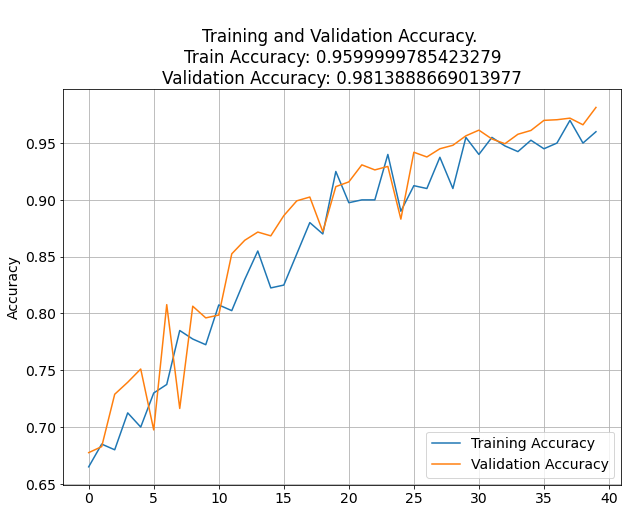

In [109]:
acc = history_bert.history['accuracy']
val_acc = history_bert.history['val_accuracy']
loss = history_bert.history['loss']
val_loss = history_bert.history['val_loss']
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

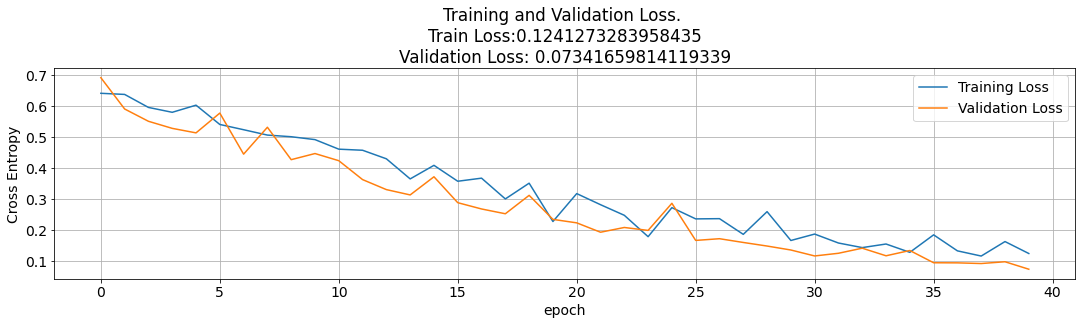

In [110]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [111]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=128, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

In [112]:
df_test = test_df

In [113]:
df_test['clean_text']=test_df['Tweet'].apply(clean_text)
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_test['final_text']=df_test['clean_text'].apply(preprocessdata)

In [114]:
# df_test['text'] = df_test['text'].fillna('empty')
pred_results=[]
for i in tqdm(df_test.Tweet):        
    processed_data = prepare_data(i, tokenizer)
    bert_probs = classification_model.predict(processed_data)[0]
#     bert_pred_probs.append(bert_probs)
    res=np.argmax(bert_probs)
    pred_results.append(res)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 60ms/step


In [115]:
submission = pd.DataFrame()
submission['TweetID'] = df_test['TweetID']
submission['Label'] = pred_results

submission.to_csv('/content/drive/MyDrive/Data/submissionsu3.csv', index=False)